##### Flow:
1. load, reshape and split in test and train all the images
2. instantiate a cnn model 
3. run the model on train and test data to verify how many epochs are more or less needed to get a nice model
4. use that number of epochs to run cross validation (pass the whole 'set_' of images to the cross validation). Repeat from 2 with another model and compare.


- If you notice that you hardly overfit maybe remove/decrease the dropout layers (e.g. from 0.25 to 0.15)
- Try building a model that predicts directly 16x16

In [1]:
%matplotlib inline

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
set_session(tf.Session(config=config))

import matplotlib.pyplot as plt
from datetime import datetime

# keras functions
from keras import callbacks
from keras import preprocessing
from keras.preprocessing import image

# our libraries
from preprocessing import *

from cnn_models import *
from evaluate import *

import scipy as scipy
from mask_to_submission import *

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Overview
The goal here is to use the CNN to reduce the size of the input image to obtain a "discretized" image of shape, e.g. (W/16, H/16). Every entry of this image is related to a patch in the input image. This obtained image is compared by the CNN with the groundtruth (after properly discretizing by it patch-wise).

### - Load data

In [2]:
# Loaded a set of images
n = 100

imgs, gt_imgs = load_images(n)
imgs[0].shape, gt_imgs[0].shape

Loading 100 images


((400, 400, 3), (400, 400))

### - Reshape the data
We reshape each input to fulfill our cnn inputs and output shape.

In [3]:
# !!! set predict_patch_width in accordance to the model you are using !!!
# the shape of the output of the model depends on the strides parameters 
# (if a layer has stride=2 then each ouput's side is half of the input'side).
# predict_patch_width must be equal to the total reduction of the model, e.g.
# if the model has three layer with stride=2 => the input of the model is 
# reduced by a factor of 2*2*2=8, i.e. the ouptut will be patch-wise with 
# patches 8x8 pixels.
predict_patch_width = 8

X, Y = images_to_XY(imgs, gt_imgs, predict_patch_width=predict_patch_width)

set_ = SimpleNamespace()
set_.X = X
set_.Y = Y

X.shape, Y.shape

((100, 400, 400, 3), (100, 50, 50))

### - For now avoid cross validation, just split the datasest in test and train. 

In [3]:
test_ratio = 0.04

train, test = split_train_test(imgs, gt_imgs, test_ratio=test_ratio, seed=1)
train.X.shape,train.Y.shape,test.X.shape,test.Y.shape

((96, 400, 400, 3), (96, 400, 400), (4, 400, 400, 3), (4, 400, 400))

In [ ]:
# # check it makes sense (show the i-th input of set_)
# i = 0
# set_ = test

# fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# axs[0].imshow(set_.Y[i, :, :, 1], cmap='gray')
# axs[1].imshow(set_.X[i, :, :])

### - Build the CNN model or load a previous one

- Choose one of the models you defined (with model_n) and initialize it.

In [4]:
# generate an unique name for the model (so to avoid overwriting previous models)
folder_name = "model_"+str('{0:%Y-%m-%d_%H%M%S}'.format(datetime.now()))
model_path = "..\\models\\"+folder_name
model = CnnModel(model_n=7, model_path=model_path)
model.summary()

model_leakyrelu_maxpooling
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 48)    17472     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, None, 48)    0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 48)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 48)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    150592    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, None, 64)    0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 6

- Otherwise load a previous model

In [6]:
# give the folder
folder_name = "model_2017-12-17_130123"
model_path = "..\models\\"+folder_name
model = CnnModel(model_n = 7,model_path=model_path)
#model.load() # load the model and its weights
model.load_weights("2017-12-17_160742_best-weightsmodel_leakyrelu_maxpooling.hdf5")
model.summary()

model_leakyrelu_maxpooling
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, None, None, 48)    17472     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, None, None, 48)    0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, None, None, 48)    0         
_________________________________________________________________
dropout_5 (Dropout)          (None, None, None, 48)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    150592    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, None, None, 64)    0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, None, None, 6

### - Train the model on the train data while validating it on the test data

In [27]:
train.X.shape[0]

80

In [11]:
# pass a batch size which is a factor of train.shape[0] so that all the batches are fo the same size
from cnn_models import *

num_epochs=30
batch_size=4
_ = model.train(train, test=test, num_epochs=num_epochs, batch_size=batch_size, monitor='loss') 

Epoch 1/30
16/24 [===================>..........] - ETA: 8s - loss: 0.1148 - acc: 0.9539Interrupt


In [12]:
model.save()

Saved model to disk


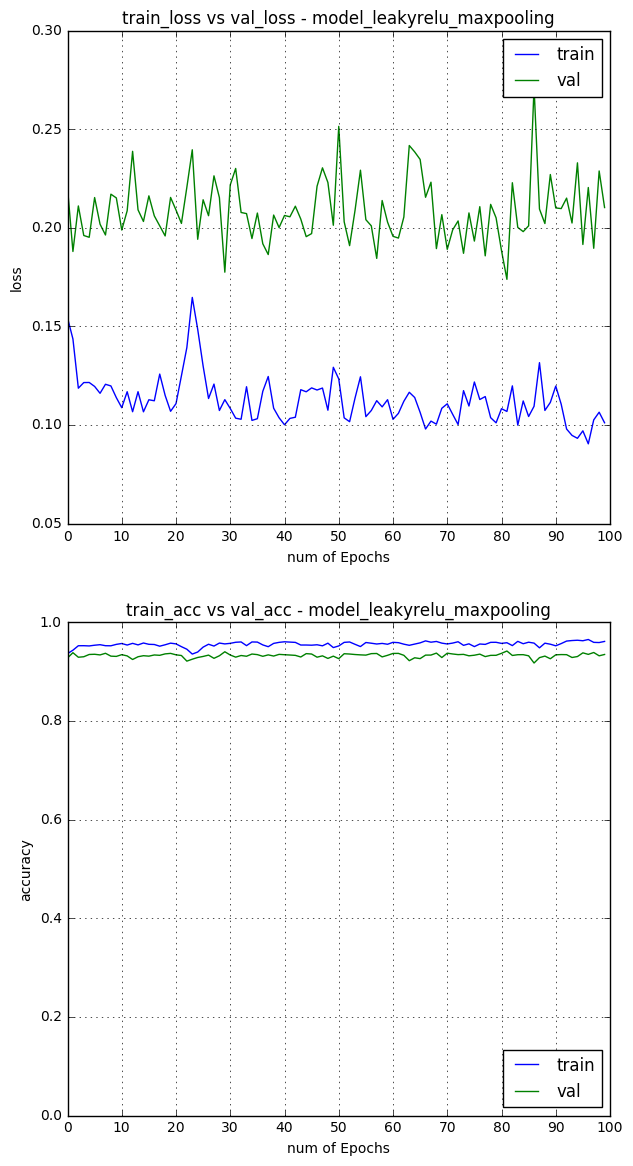

In [10]:
model.plot_history()

### - Run cross validation to evaluate the model

In [ ]:
num_epochs=10
batch_size=3
result = model.cross_validation(set_, batch_size=batch_size, num_epochs=num_epochs)
result

In [ ]:
# plot the histories of the cross validation
plot_history(result["history_mean"]) 
# history of the folds (check if there is a worst case)
# plot_history(result["histories"][0]) 
# plot_history(result["histories"][1]) 
# plot_history(result["histories"][2]) 
# plot_history(result["histories"][3]) 

#### Plot the accuracy and the loss obtained during training

In [ ]:
last_epochs=20 # plot only the last n epochs
model.plot_history(last_epochs=last_epochs)

#### Display the output of a specific layer

In [ ]:
# these are all the layers 
model.model.layers

In [ ]:
# choose a layer and an image 
image = test.X[0]
layer_num = 8

model.show_layer_output(image, layer_num, filename="") # pass a filename if you want to store the image to file 

### - Evaluate the model on the test data

In [14]:
#re-evaluate on some subset
test_ratio = 0.10
train, test = split_train_test(imgs, gt_imgs, test_ratio=test_ratio, seed=1)

                precision    recall  f1-score   support

0 (background)       0.96      0.99      0.97     18170
      1 (road)       0.96      0.89      0.92      6830

   avg / total       0.96      0.96      0.96     25000

Confusion matrix, without normalization


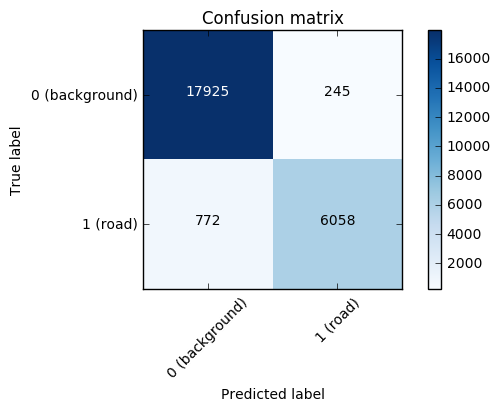

Normalized confusion matrix


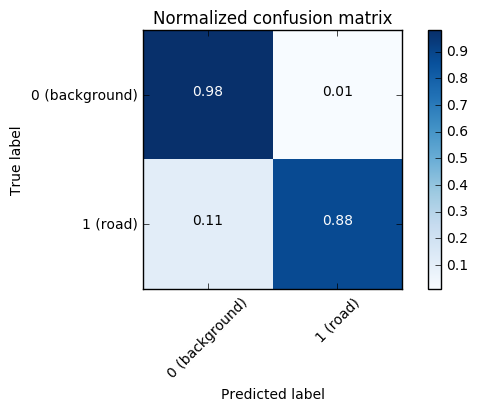

In [15]:
# check the performance on train or test


set_ = test

model.evaluate_model(set_.X, set_.Y)

In [16]:
#and reset the train set as full dataset
test_ratio = 0.04
train, test = split_train_test(imgs, gt_imgs, test_ratio=test_ratio, seed=1)

### - Show a prediction

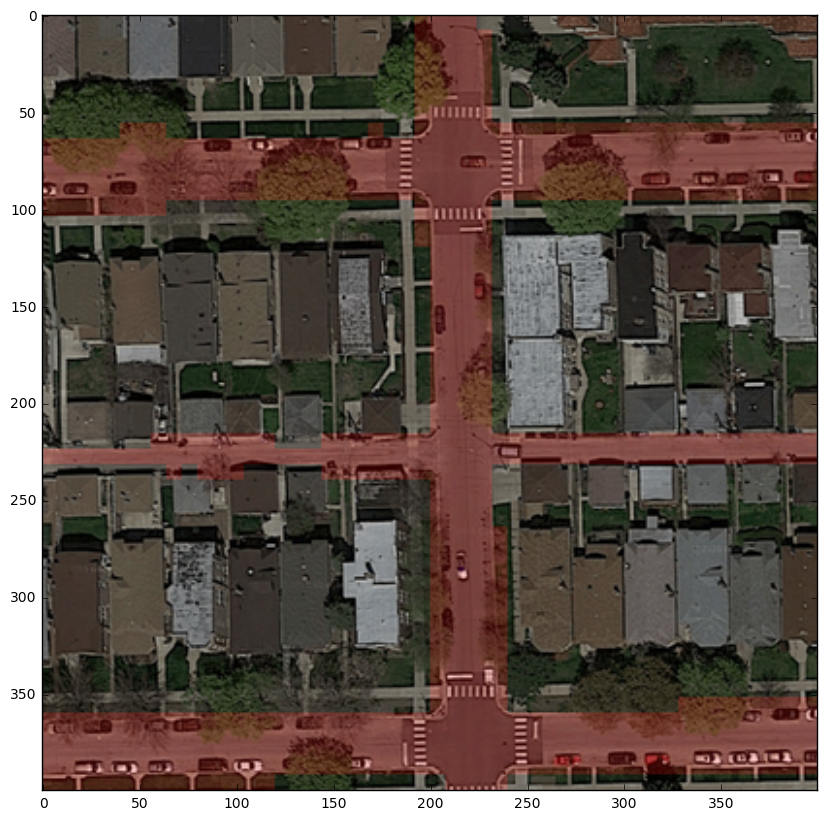

In [18]:
# choose an image to predict (or part of it)
img = train.X[33][:, :]

model.display_prediction(img, ax=None)

### Export predictions


In [19]:
from cnn_models import *
model.predict_augmented_and_export()

Loading 5 images to predict
loading image ../dataset/test_set_images/test_1/test_1.png
loading image ../dataset/test_set_images/test_2/test_2.png
loading image ../dataset/test_set_images/test_3/test_3.png
loading image ../dataset/test_set_images/test_4/test_4.png
loading image ../dataset/test_set_images/test_5/test_5.png
Predicting image 0
	Flipping image: False
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
	Flipping image: True
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
Predicting image 1
	Flipping image: False
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
	Flipping image: True
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degre

C:\Program Files\Anaconda3\lib\site-packages\imageio\core\util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


Loading 5 images to predict
loading image ../dataset/test_set_images/test_6/test_6.png
loading image ../dataset/test_set_images/test_7/test_7.png
loading image ../dataset/test_set_images/test_8/test_8.png
loading image ../dataset/test_set_images/test_9/test_9.png
loading image ../dataset/test_set_images/test_10/test_10.png
Predicting image 0
	Flipping image: False
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
	Flipping image: True
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
Predicting image 1
	Flipping image: False
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
	Flipping image: True
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 deg

### - Save/load model

In [ ]:
model.save()

## multiple models testing

In [5]:
folder_name = "model_"+str('{0:%Y-%m-%d_%H%M%S}'.format(datetime.now()))


In [6]:
from cnn_models import *
#models = [
#0          model1,
#1          model2,
#2          additional_conv_layer_model,
#3          max_pooling_model,
#4          leaky_relu_model,
#5          decreased_dropout_model,
#6          many_filters_model, 
#7          model_leakyrelu_maxpooling, 
#8          model_relu_maxpooling] 
models_to_train =  [7]
for i in models_to_train:
    # generate an unique name for the model (so to avoid overwriting previous models)
    model_path = "..\\models\\"+folder_name
    model = CnnModel(model_n=i, model_path=model_path)
    model.summary()
    num_epochs=3
    batch_size=2
    _ = model.train(train, test=test, num_epochs=num_epochs, batch_size=batch_size, monitor='val_loss') 
    model.save()
    model.plot_history()

model_leakyrelu_maxpooling
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 64)    9472      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, None, 64)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 128)   204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, None, 128)   0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
dropout_2 (Dropout)          (None, None, None, 1

ResourceExhaustedError: OOM when allocating tensor with shape[2,128,400,400]
	 [[Node: training/Adam/gradients/max_pooling2d_1/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, _class=["loc:@max_pooling2d_1/MaxPool"], data_format="NHWC", ksize=[1, 2, 2, 1], padding="SAME", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](leaky_re_lu_2/sub, max_pooling2d_1/MaxPool, training/Adam/gradients/AddN_8)]]

Caused by op 'training/Adam/gradients/max_pooling2d_1/MaxPool_grad/MaxPoolGrad', defined at:
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Program Files\Anaconda3\lib\site-packages\traitlets\config\application.py", line 653, in launch_instance
    app.start()
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-2ff665f980a9>", line 20, in <module>
    _ = model.train(train, test=test, num_epochs=num_epochs, batch_size=batch_size, monitor='val_loss')
  File "C:\Users\Val\Desktop\road-segmentation\scripts\cnn_models.py", line 199, in train
    callbacks=callbacks_list
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\models.py", line 1223, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\training.py", line 1996, in fit_generator
    self._make_train_function()
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\optimizers.py", line 415, in get_updates
    grads = self.get_gradients(loss, params)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\optimizers.py", line 73, in get_gradients
    grads = K.gradients(loss, params)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 2389, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 581, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 353, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 581, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_grad.py", line 555, in _MaxPoolGrad
    data_format=op.get_attr("data_format"))
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 3082, in _max_pool_grad
    data_format=data_format, name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'max_pooling2d_1/MaxPool', defined at:
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-2ff665f980a9>", line 16, in <module>
    model = CnnModel(model_n=i, model_path=model_path)
  File "C:\Users\Val\Desktop\road-segmentation\scripts\cnn_models.py", line 49, in __init__
    self.model = models[model_n]()
  File "C:\Users\Val\Desktop\road-segmentation\scripts\cnn_models.py", line 987, in model_leakyrelu_maxpooling
    model.add(MaxPooling2D(padding="same",pool_size=pool_size))
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\models.py", line 489, in add
    output_tensor = layer(self.outputs[0])
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\layers\pooling.py", line 154, in call
    data_format=self.data_format)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\layers\pooling.py", line 217, in _pooling_function
    pool_mode='max')
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 3460, in pool2d
    data_format=tf_data_format)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1958, in max_pool
    name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 2805, in _max_pool
    data_format=data_format, name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[2,128,400,400]
	 [[Node: training/Adam/gradients/max_pooling2d_1/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, _class=["loc:@max_pooling2d_1/MaxPool"], data_format="NHWC", ksize=[1, 2, 2, 1], padding="SAME", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](leaky_re_lu_2/sub, max_pooling2d_1/MaxPool, training/Adam/gradients/AddN_8)]]


### - Others

In [ ]:
# some callbacks example: 

# create a list of callbacks we want to use during training
# # a callback to store epoch results to a csv file
# filename='model_train_new.csv'
# csv_log = callbacks.CSVLogger(filename, separator=',', append=False)

# # a callback to stob before doing the predefined number of epochs (stop before overfitting the data)
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min')

# # a callback to save the best model (best model = the one with the lowest 'monitor' variable)
# filepath = "best-weights-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"
# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# # callbacks_list = [csv_log,early_stopping,checkpoint]

print(
    "-get configurations:", "\n",
    model.get_config(), "\n",
    model.layers[0].get_config(), "\n",

    "\n-get shapes", "\n",
    model.layers[0].input_shape, "\n",
    model.layers[0].output_shape, "\n",
    
    "\n-get weights", "\n",
    model.layers[0].get_weights()[0].shape, "\n",
    
    "\n-check if trainable", "\n",
    model.layers[0].trainable, "\n", # you can set this to false to "freeze" a layer
)

In [ ]:
from IPython.core.debugger import Pdb
debugger = Pdb()
debugger.set_trace() # put this line as a breakpoint

Test batch generation

In [ ]:
gen1, gen2 = image_generators(X, Y) 

In [ ]:
from cnn_models import batches_generator
j = 0
x_batches = []
y_batches = []

for x, y in batches_generator(X[:4], Y[:4], batch_size = 4):
    j += 1
    if j > 10:
        break
    x_batches.append(x)
    y_batches.append(y)

In [ ]:
np.array(x_batches).shape, np.array(y_batches).shape

In [ ]:
b = 0
i = -1

In [ ]:
i += 1
if i >= x_batches[0].shape[0]:
    i = 0
    b += 1
print("Batch", str(b) + ". Image", i)
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((20, 10))
axs[0].imshow(x_batches[b][i], cmap='gray')
axs[1].imshow(y_batches[b][i][:, :, 1], cmap='gray')